In [1]:
# a notebook on EM segmentation task with the U-net architecture

# dataset from isbi 2012 challenge
# https://imagej.net/events/isbi-2012-segmentation-challenge
# detailed explanation of the task can be found on the website
# downsampled to 256*256

In [2]:
!git clone https://github.com/hongh-zhang/Vision.git

Cloning into 'CV-playground'...
remote: Enumerating objects: 273, done.
remote: Counting objects: 100% (273/273), done.
remote: Compressing objects: 100% (265/265), done.
remote: Total 273 (delta 7), reused 267 (delta 5), pack-reused 0
Receiving objects: 100% (273/273), 35.05 MiB | 48.24 MiB/s, done.
Resolving deltas: 100% (7/7), done.


# Preprocess

In [3]:
import os
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

path = 'Vision/em/data/'

In [4]:
img = cv2.imread(path+'downsampled/images/train-volume00.jpg', cv2.IMREAD_GRAYSCALE)
lbl = cv2.imread(path+'downsampled/labels/train-labels00.jpg', cv2.IMREAD_GRAYSCALE)

[[122 128 138 ... 162 153 153]
 [131 138 142 ... 158 144 156]
 [112 140 146 ... 158 153 180]
 ...
 [196 188 165 ... 162 119 118]
 [165 168 151 ... 187 159 119]
 [155 159 155 ... 210 180 149]]


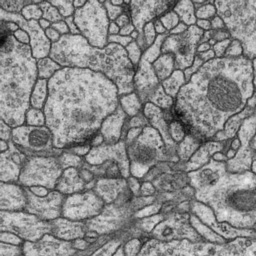

In [5]:
print(img)
cv2_imshow(img)

In [6]:
images = []
labels = []

# read in images
for img_file, lbl_file in zip(sorted(os.listdir(path+'downsampled/images')), 
                 sorted(os.listdir(path+'downsampled/labels'))):
  
    img = cv2.imread(os.path.join(path+'downsampled/images',img_file), cv2.IMREAD_GRAYSCALE)
    lbl = cv2.imread(os.path.join(path+'downsampled/labels',lbl_file), cv2.IMREAD_GRAYSCALE)

    images.append(img)
    labels.append(lbl)

    # flip for augmentation
    for flipcode in [-1,0,1]:
        img2 = cv2.flip(img, flipcode)
        lbl2 = cv2.flip(lbl, flipcode)
        images.append(img2)
        labels.append(lbl2)

In [7]:
# values are normalized into the 0-1 range to speed up convergence

# taking the first 5 images as test set
img_test = np.array(images, dtype=float)[:5].reshape(-1, 256, 256, 1) / 255.0
lbl_test = np.round_(np.array(labels, dtype=float)[:5].reshape(-1, 256, 256, 1) / 255.0)

images = np.array(images, dtype=float)[5:].reshape(-1, 256, 256, 1) / 255.0
labels = np.round_(np.array(labels, dtype=float)[5:].reshape(-1, 256, 256, 1) / 255.0)

images.shape

(115, 256, 256, 1)

In [8]:
# TODO: add more augmentation
# brightness / contrast
# blurring
# noising

# Train

In [9]:
import tensorflow as tf
from tensorflow.keras import layers

In [10]:
images = tf.convert_to_tensor(images)
labels = tf.convert_to_tensor(labels)

img_test = tf.convert_to_tensor(img_test)
lbl_test = tf.convert_to_tensor(lbl_test)

In [11]:
class Model(tf.keras.Model):
    def __init__(self):
        super().__init__()

        self.dropout = layers.Dropout(0.2)

        self.conv1 = tf.keras.Sequential([
            layers.Conv2D(64, 3, activation='ReLU', padding='same'),
            layers.Conv2D(64, 3, activation='ReLU', padding='same'),
        ])
        self.conv2 = tf.keras.Sequential([
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Conv2D(128, 3, activation='ReLU', padding='same'),
            layers.Conv2D(128, 3, activation='ReLU', padding='same'),
            layers.Conv2D(128, 3, activation='ReLU', padding='same'),
        ])
        self.conv3 = tf.keras.Sequential([
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Conv2D(256, 3, activation='ReLU', padding='same'),
            layers.Conv2D(256, 3, activation='ReLU', padding='same'),
            layers.Conv2D(256, 3, activation='ReLU', padding='same'),
        ])

        self.bottom = tf.keras.Sequential([
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Conv2D(512, 3, activation='ReLU', padding='same'),
            layers.Conv2D(512, 3, activation='ReLU', padding='same'),
            layers.UpSampling2D(size=(2,2))
        ])

        self.deconv1 = tf.keras.Sequential([
            layers.Conv2D(256, 3, activation='ReLU', padding='same'),
            layers.Conv2D(256, 3, activation='ReLU', padding='same'),
            layers.UpSampling2D(size=(2,2))
        ])
        self.deconv2 = tf.keras.Sequential([
            layers.Conv2D(128, 5, activation='ReLU'),
            layers.Conv2D(128, 5, activation='ReLU'),
            layers.Conv2D(128, 5, activation='ReLU'),
            layers.UpSampling2D(size=(2,2))
        ])

        self.out = tf.keras.Sequential([
            layers.Conv2D(64, 5, activation='ReLU'),
            layers.Conv2D(64, 3, activation='ReLU'),

            # output layer has 2 channel 
            # for probability of membrane & non-membrane
            layers.Conv2D(2, 3, activation='softmax'),
        ])

    def call(self, X, training=True):

        # add border padding & noise
        X = tf.pad(X, tf.constant([[0,0], [16, 16], [16, 16], [0,0]]), 'REFLECT')
        X0 = X[:, 12:-12, 12:-12, :]
        X = self.dropout(X, training=training)

        # contracting path
        X = self.conv1(X)
        X2 = self.conv2(X)  # output are cached for later use
        X3 = self.conv3(X2)
        X = self.bottom(X3)

        # expansive path
        # low level features are combined with higher resolution maps
        X = tf.concat([X, X3], 3)
        X = self.deconv1(X)
        X = tf.concat([X, X2], 3)
        X = self.deconv2(X)
        X = tf.concat([X, X0], 3)
        X = self.out(X)
        return X

In [12]:
nn = Model()
nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4, name='Adam',), loss='SparseCategoricalCrossentropy')
nn(images[0:1]).shape

TensorShape([1, 256, 256, 2])

In [13]:
nn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           multiple                  0         
                                                                 
 sequential (Sequential)     (1, 276, 276, 64)         37568     
                                                                 
 sequential_1 (Sequential)   (1, 132, 132, 128)        369024    
                                                                 
 sequential_2 (Sequential)   (1, 60, 60, 256)          1475328   
                                                                 
 sequential_3 (Sequential)   (1, 60, 60, 512)          3539968   
                                                                 
 sequential_4 (Sequential)   (1, 132, 132, 256)        2949888   
                                                                 
 sequential_5 (Sequential)   (1, 256, 256, 128)        590080

In [14]:
nn.fit(x=images, y=labels, shuffle=True, batch_size=16, epochs=60, 
    verbose='auto', validation_data=(img_test, lbl_test));

Epoch 1/60
8/8 [==============================] - 55s 3s/step - loss: 0.6444 - val_loss: 0.6146
Epoch 2/60
8/8 [==============================] - 11s 1s/step - loss: 0.5695 - val_loss: 0.5220
Epoch 3/60
8/8 [==============================] - 11s 1s/step - loss: 0.5117 - val_loss: 0.5108
Epoch 4/60
8/8 [==============================] - 11s 1s/step - loss: 0.5015 - val_loss: 0.5103
Epoch 5/60
8/8 [==============================] - 11s 1s/step - loss: 0.4958 - val_loss: 0.5021
Epoch 6/60
8/8 [==============================] - 11s 1s/step - loss: 0.4871 - val_loss: 0.4882
Epoch 7/60
8/8 [==============================] - 11s 1s/step - loss: 0.4670 - val_loss: 0.4543
Epoch 8/60
8/8 [==============================] - 11s 1s/step - loss: 0.4402 - val_loss: 0.4157
Epoch 9/60
8/8 [==============================] - 11s 1s/step - loss: 0.4019 - val_loss: 0.3780
Epoch 10/60
8/8 [==============================] - 11s 1s/step - loss: 0.3743 - val_loss: 0.3557
Epoch 11/60
8/8 [======================

raw image


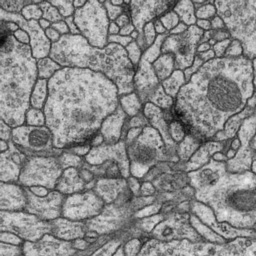


true label


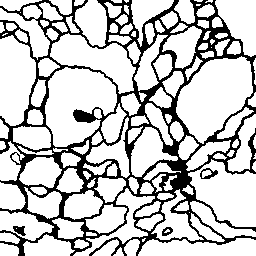


predicted


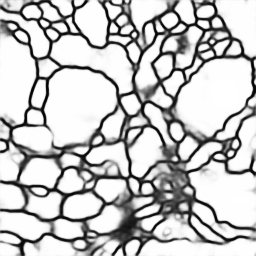

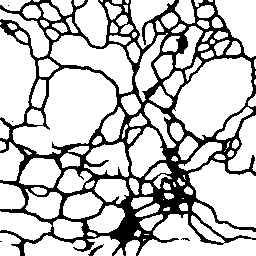

In [15]:
print('raw image')
cv2_imshow(img_test[0:1].numpy().reshape(256, 256)*255)
print('\ntrue label')
cv2_imshow(lbl_test[0:1].numpy().reshape(256, 256)*255)

print('\npredicted')
cv2_imshow(nn(img_test[0:1], training=False).numpy().reshape(256, 256, 2)[:,:,1] * 255)

# or a 'hard' version by calling argmax:
print('')
cv2_imshow(np.argmax(nn(img_test[0:1], training=False).numpy().reshape(256, 256, 2), axis=2) * 255)